In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

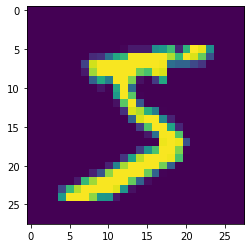



tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [12]:
torch.cuda.is_available()

True

In [14]:
!nvidia-smi

Wed May 27 08:46:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [17]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9105, device='cuda:0')
tensor(0.9071, device='cuda:0')
tensor(0.9141, device='cuda:0')
tensor(0.9213, device='cuda:0')
tensor(0.9238, device='cuda:0')
tensor(0.9245, device='cuda:0')
tensor(0.9251, device='cuda:0')
tensor(0.9269, device='cuda:0')
tensor(0.9245, device='cuda:0')
tensor(0.9323, device='cuda:0')
tensor(0.9309, device='cuda:0')
tensor(0.9335, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9344, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9377, device='cuda:0')
tensor(0.9316, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9424, device='cuda:0')
tensor(0.9423, device='cuda:0')
tensor(0.9425, device='cuda:0')
tensor(0.9445, device='cuda:0')
tensor(0.9451, device='cuda:0')
tensor(0.9440, device='cuda:0')
tensor(0.9426, device='cuda:0')
tensor(0.9478, device='cuda:0')
tensor(0.9432, device='cuda:0')
tensor(0.9454, device='cuda:0')
tensor(0.9461, device='cuda:0')
tensor(0.9425, device='cuda:0')
tensor(0

KeyboardInterrupt: ignored

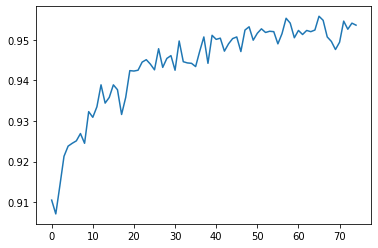

In [19]:
plt.plot(test_accuracy_history)

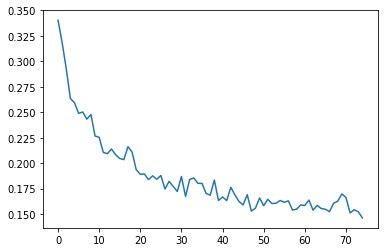

In [20]:
plt.plot(test_loss_history);